In [42]:
import fwiVis.fwiVis as fv 
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
import zarr #Didn't build into the env, needed to run "mamba install -c conda-forge zarr" took awhile, and was killed w/out mamba. Wait, it actually only worked with pip? 
import rasterio
from rasterio.plot import plotting_extent
import datetime as dt
from datetime import timedelta, date
import bottleneck ## needed to run  pip install bottleneck in terminal after activating fireatlas_oct4_2 conda env

xr.set_options(use_bottleneck=True) ## Maybe can get away with not importing botteneck? 


In [43]:
## Calculating IMERGE percentiles



geos_fwi = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr", engine="zarr")


In [44]:
geos_fwi


g_fwi  = geos_fwi["GPM.LATE.v5_FWI"]
#g_fwi = g_fwi.rio.set_spatial_dims(x_dim= "lat", y_dim = "lon")
#print(min_lon)
#g_fwi.lon

#gsmall = g_fwi.sel(time ="2021-08", drop = True)

min_lat = 38.5
max_lat = 39.0
min_lon = -121.0 
max_lon = -119.50

gsmall = g_fwi.sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))
gffmc = geos_fwi["GPM.LATE.v5_FFMC"]
gisi = geos_fwi["GPM.LATE.v5_ISI"]
gdc = geos_fwi["GPM.LATE.v5_DC"]
gdmc = geos_fwi["GPM.LATE.v5_DMC"]

#gsmall.sel(time = "2021-08-01").plot()

gtime = g_fwi.sel(lat = min_lat, lon = min_lon, method = "nearest")

gsmall

<xarray.DataArray 'GPM.LATE.v5_FWI' (time: 3200, lat: 5, lon: 15)>
[240000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 38.55 38.65 38.75 38.85 38.95
  * lon      (lon) float64 -120.9 -120.8 -120.8 -120.6 ... -119.8 -119.6 -119.5
  * time     (time) datetime64[ns] 2014-05-01 2014-05-02 ... 2023-02-02
Attributes:
    long_name:   GPM.LATE.v5 Fire Weather Index
    short_name:  GPM.LATE.v5_FWI
    units:

In [45]:
gtime

<xarray.DataArray 'GPM.LATE.v5_FWI' (time: 3200)>
array([20.441446, 18.964592, 18.919746, ...,       nan,       nan,       nan],
      dtype=float32)
Coordinates:
    lat      float64 38.45
    lon      float64 -121.0
  * time     (time) datetime64[ns] 2014-05-01 2014-05-02 ... 2023-02-02
Attributes:
    long_name:   GPM.LATE.v5 Fire Weather Index
    short_name:  GPM.LATE.v5_FWI
    units:

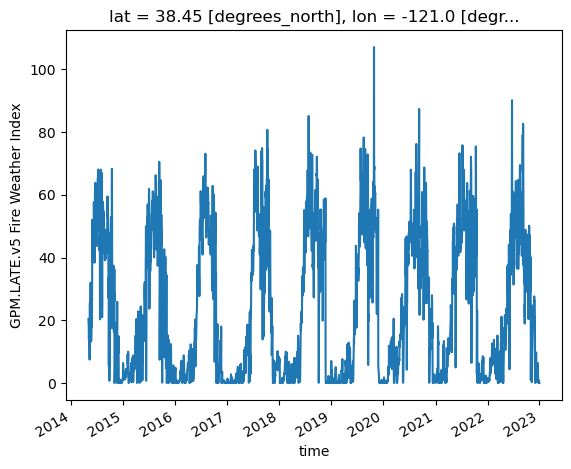

In [46]:
gtime = gtime.dropna(dim = "time")
gtime.plot()

In [47]:
test = pd.DataFrame(gtime)

In [48]:
test = np.sort(test)

In [49]:
srt = np.sort(gtime)
N = len(gtime)

y = np.arange(N) / N

#y = y / float(gtime.max())

rank = gtime.rank(dim = "time")
print(max(rank))
len(gtime)

<xarray.DataArray 'GPM.LATE.v5_FWI' ()>
array(3120.)
Coordinates:
    lat      float64 38.45
    lon      float64 -121.0
    time     datetime64[ns] 2019-10-27


3120

In [50]:
#?gtime.rank
arr = xr.DataArray([6, 5, 7], dims="x")
arr.rank("x")

<xarray.DataArray (x: 3)>
array([2., 1., 3.])
Dimensions without coordinates: x

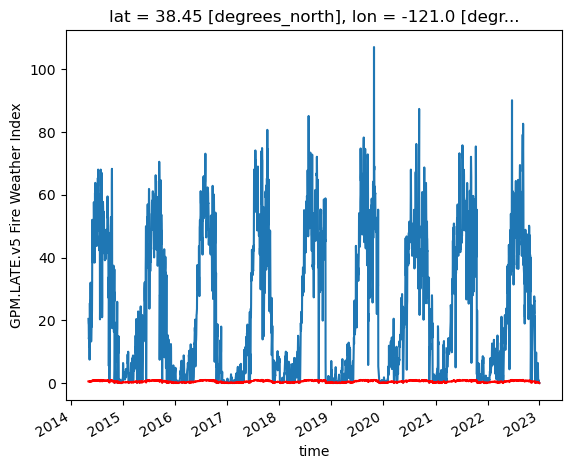

In [51]:
gtime.plot()
rank = (rank/len(gtime))# * 100
plt.plot(gtime.time, rank, "red")

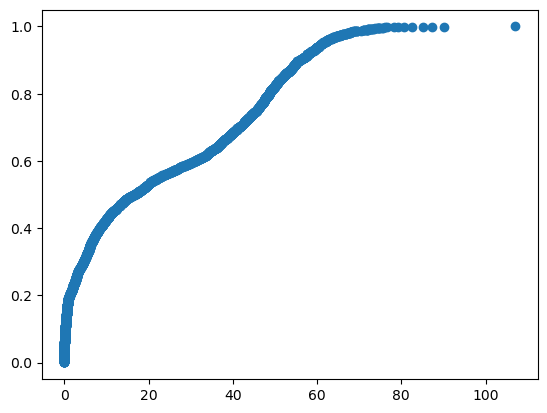

In [52]:
plt.scatter(gtime.data, rank) ## Rank

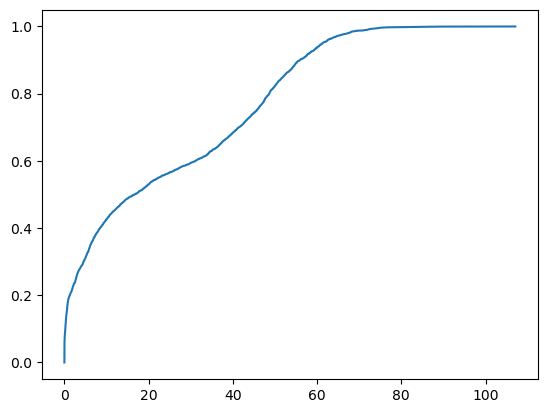

In [53]:
plt.plot(srt, y)

In [54]:
gsmall.data

array([[[20.441446 ,  8.317282 ,  8.609483 , ...,        nan,
                nan,        nan],
        [19.380054 ,  7.4877734,  6.656547 , ..., 15.232182 ,
         15.232182 , 15.232182 ],
        [19.380054 ,  7.4877734,  6.656547 , ..., 15.232182 ,
         15.232182 , 15.232182 ],
        [11.283828 ,  7.4877734,  6.656547 , ..., 15.232182 ,
         15.232182 , 15.232182 ],
        [10.854922 ,  5.8850136,  6.180775 , ..., 12.777761 ,
         12.777761 , 12.777761 ]],

       [[18.964592 ,  9.526491 , 11.7594385, ..., 16.934462 ,
         16.934462 , 16.934462 ],
        [21.662823 , 10.93254  , 11.205375 , ..., 28.884293 ,
         28.884293 , 28.884293 ],
        [21.662823 , 10.93254  , 11.205375 , ..., 28.884293 ,
         28.884293 , 28.884293 ],
        [13.903888 , 10.93254  , 11.205375 , ..., 28.884293 ,
         28.884293 , 28.884293 ],
        [13.837034 , 10.779818 , 10.278829 , ..., 26.776602 ,
         26.776602 , 26.776602 ]],

       [[18.919746 , 11.499012 , 11.

In [55]:
?xr.concat

Signature:
xr.concat(
    objs,
    dim,
    data_vars='all',
    coords='different',
    compat: 'CompatOptions' = 'equals',
    positions=None,
    fill_value=<NA>,
    join: 'JoinOptions' = 'outer',
    combine_attrs: 'CombineAttrsOptions' = 'override',
)
Docstring:
Concatenate xarray objects along a new or existing dimension.

Parameters
----------
objs : sequence of Dataset and DataArray
    xarray objects to concatenate together. Each object is expected to
    consist of variables and coordinates with matching shapes except for
    along the concatenated dimension.
dim : Hashable or DataArray or pandas.Index
    Name of the dimension to concatenate along. This can either be a new
    dimension name, in which case it is added along axis=0, or an existing
    dimension name, in which case the location of the dimension is
    unchanged. If dimension is provided as a DataArray or Index, its name
    is used as the dimension to concatenate along and the values are added
    as a coord

In [56]:
ds = xr.Dataset(

    {

        "A": (("x", "y"), [[1, 2], [3, 4]]),

        "B": (("x", "y"), [[5, 6], [7, 8]]),

    },

    coords={"x": ["b", "a"], "y": [1, 0]},

)

In [57]:
ds

<xarray.Dataset>
Dimensions:  (x: 2, y: 2)
Coordinates:
  * x        (x) <U1 'b' 'a'
  * y        (y) int64 1 0
Data variables:
    A        (x, y) int64 1 2 3 4
    B        (x, y) int64 5 6 7 8

In [58]:
dax = xr.DataArray([100, 99], [("x", [0, 1])])
day = xr.DataArray([90, 80], [("y", [0, 1])])

ds.sortby([day, dax])

<xarray.Dataset>
Dimensions:  (x: 2, y: 2)
Coordinates:
  * x        (x) <U1 'b' 'a'
  * y        (y) int64 1 0
Data variables:
    A        (x, y) int64 1 2 3 4
    B        (x, y) int64 5 6 7 8

In [59]:
caldor = geos_fwi.sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))

In [60]:
caldor

<xarray.Dataset>
Dimensions:           (time: 3200, lat: 5, lon: 15)
Coordinates:
  * lat               (lat) float64 38.55 38.65 38.75 38.85 38.95
  * lon               (lon) float64 -120.9 -120.8 -120.8 ... -119.6 -119.5
  * time              (time) datetime64[ns] 2014-05-01 2014-05-02 ... 2023-02-02
Data variables:
    GPM.LATE.v5_BUI   (time, lat, lon) float32 ...
    GPM.LATE.v5_DC    (time, lat, lon) float32 ...
    GPM.LATE.v5_DMC   (time, lat, lon) float32 ...
    GPM.LATE.v5_DSR   (time, lat, lon) float32 ...
    GPM.LATE.v5_FFMC  (time, lat, lon) float32 ...
    GPM.LATE.v5_FWI   (time, lat, lon) float32 ...
    GPM.LATE.v5_ISI   (time, lat, lon) float32 ...
Attributes: (12/46)
    Center:              NASA GISS / Columbia University
    Center::             center
    DCDryStartFactor:    5.0
    DCDryStartFactor::   DC number of days since precip mult factor for dry s...
    DCStart:             15.0
    DCStart::            DC starting value after wet winter
    ...                  ...
    snowCoverDaysCalc:   60.0
    snowCoverDaysCalc::  Number of days prior to spring over which to determi...
    startShutDays:       2.0
    startShutDays::      Number of previous days over which to consider start...
    tempThresh:          6.0
    tempThresh::         Temp thresh (C) to define start and end of winter

In [61]:
rank = caldor["GPM.LATE.v5_FWI"].rank(dim = "time" )

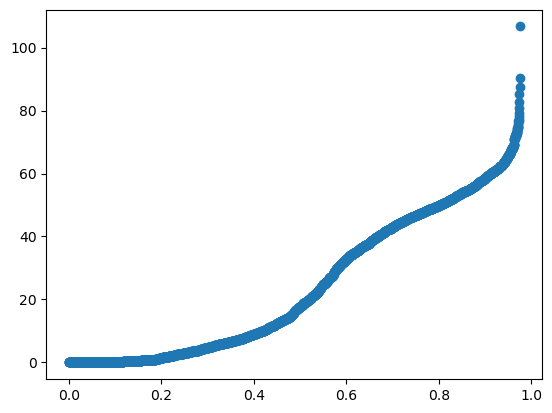

In [70]:
r_len = len(rank.sel(lon = min_lon, lat = min_lat, method = "nearest").data)

plt.scatter(rank.sel(lon = min_lon, lat = min_lat, method = "nearest").data/r_len, caldor["GPM.LATE.v5_FWI"].sel(lon = min_lon, lat = min_lat, method = "nearest").data)

In [63]:
caldor = caldor.assign(FWI_rank = rank)

In [64]:
mean_fwi = caldor["GPM.LATE.v5_FWI"].mean(dim = "time")
caldor = caldor.assign(FWI_anomolies = lambda x: x["GPM.LATE.v5_FWI"] - mean_fwi)

In [68]:
?caldor.rename

Signature:
caldor.rename(
    name_dict: 'Mapping[Any, Hashable] | None' = None,
    **names: 'Hashable',
) -> 'T_Dataset'
Docstring:
Returns a new object with renamed variables, coordinates and dimensions.

Parameters
----------
name_dict : dict-like, optional
    Dictionary whose keys are current variable, coordinate or dimension names and
    whose values are the desired names.
**names : optional
    Keyword form of ``name_dict``.
    One of name_dict or names must be provided.

Returns
-------
renamed : Dataset
    Dataset with renamed variables, coordinates and dimensions.

See Also
--------
Dataset.swap_dims
Dataset.rename_vars
Dataset.rename_dims
DataArray.rename
File:      ~/myenvs/fireatlas_oct4/lib/python3.8/site-packages/xarray/core/dataset.py
Type:      method


In [164]:
def imerge_climate(imerge ,clim = ["rank_anomolie"], var = ["FWI"]):
    '''
   Takes an imerge xararay dataset and calculated the rank|anomolies|rank_anomolies across time fore each pixel.   
    
    INPUTS:
        
        imerge (Xarray.Dataset): IMERGE FWI data in intermediate variables 
        clim ([str]): List of climate statistics to calcualte. Options "rank", "anomolie", and "rank_anomolie". "rank" or data betwee 0-1. 1 is largest data, 0 is smallest. "anomolie" will take the mean over the "time" dimention and subtract the mean from each point in time. "rank_anomolie" first calcualtes anomolies by substracting the mean and then ranks those anomolies. 
        var ([str]): Which variables to calculate the climate stats on. Defaults to "FWI", but "BUI", "DC", "DMC", "DSR", "FFMC",  and "ISI" are available. 
    
    '''
    
    clim_ok = all(x in ["rank", "anomolie","rank_anomolie"] for x in clim)
    
    if(not clim_ok):
        raise ValueError("clim is not one of the allowed options: ", clim_options)
    
    for v in var:
        
        v_long = "GPM.LATE.v5_" + v

        if( ("anomolie" in clim) | ("rank_anomolie" in clim) ):
            mean = imerge[v_long].mean(dim = 'time')
            var_name = v + "_anomolie"
            print("Assignign variable " + var_name)
            imerge = imerge.assign( foo = imerge[v_long] - mean)
            imerge = imerge.rename({"foo": var_name })
            
        if("rank" in clim):
            rank = imerge[v_long].rank(dim = "time")
            var_name_rank = v + "_rank"
            print("Assignign variable " + var_name_rank)
            imerge = imerge.assign(foo2 = rank)
            imerge = imerge.rename({"foo2": var_name_rank})
        
        if("rank_anomolie" in clim):
            rank_am = imerge[var_name].rank(dim = "time")
            var_name_rank_am = v + "_rank_anomolies"
            print("Assignign variable " + var_name_rank_am)
            imerge = imerge.assign(foo3 = rank_am)
            imerge = imerge.rename({"foo3" : var_name_rank_am})
        
     
    return(imerge)
    
        

In [132]:
print(list(caldor.keys())) - "GPM.LATE.v5"

['GPM.LATE.v5_BUI', 'GPM.LATE.v5_DC', 'GPM.LATE.v5_DMC', 'GPM.LATE.v5_DSR', 'GPM.LATE.v5_FFMC', 'GPM.LATE.v5_FWI', 'GPM.LATE.v5_ISI', 'FWI_rank', 'FWI_anomolies']


TypeError: unsupported operand type(s) for -: 'NoneType' and 'str'

In [126]:
test = "fish"

blist = ["fish", "turtle", "ice cream"]
#blist = ["fish"]

In [130]:
temp = ["fish", "snake"] #  "snake"

all(x in blist for x in temp)

False

In [170]:
temp_caldor = imerge_climate(caldor, var = ["ISI"])

Assignign variable ISI_anomolie
Assignign variable ISI_rank_anomolies


In [171]:
temp_caldor

<xarray.Dataset>
Dimensions:             (time: 3200, lat: 5, lon: 15)
Coordinates:
  * lat                 (lat) float64 38.55 38.65 38.75 38.85 38.95
  * lon                 (lon) float64 -120.9 -120.8 -120.8 ... -119.6 -119.5
  * time                (time) datetime64[ns] 2014-05-01 ... 2023-02-02
Data variables:
    GPM.LATE.v5_BUI     (time, lat, lon) float32 45.37 14.7 12.81 ... nan nan
    GPM.LATE.v5_DC      (time, lat, lon) float32 ...
    GPM.LATE.v5_DMC     (time, lat, lon) float32 ...
    GPM.LATE.v5_DSR     (time, lat, lon) float32 ...
    GPM.LATE.v5_FFMC    (time, lat, lon) float32 ...
    GPM.LATE.v5_FWI     (time, lat, lon) float32 20.44 8.317 8.609 ... nan nan
    GPM.LATE.v5_ISI     (time, lat, lon) float32 9.523 6.376 7.189 ... nan nan
    FWI_rank            (time, lat, lon) float64 1.677e+03 1.247e+03 ... nan nan
    FWI_anomolies       (time, lat, lon) float32 -3.654 -15.76 ... nan nan
    ISI_anomolie        (time, lat, lon) float32 1.793 -1.347 -1.803 ... nan nan
    ISI_rank_anomolies  (time, lat, lon) float64 1.989e+03 1.675e+03 ... nan nan
Attributes: (12/46)
    Center:              NASA GISS / Columbia University
    Center::             center
    DCDryStartFactor:    5.0
    DCDryStartFactor::   DC number of days since precip mult factor for dry s...
    DCStart:             15.0
    DCStart::            DC starting value after wet winter
    ...                  ...
    snowCoverDaysCalc:   60.0
    snowCoverDaysCalc::  Number of days prior to spring over which to determi...
    startShutDays:       2.0
    startShutDays::      Number of previous days over which to consider start...
    tempThresh:          6.0
    tempThresh::         Temp thresh (C) to define start and end of winter

In [151]:
clim == "rank_anomolie"

NameError: name 'clim' is not defined

SyntaxError: invalid syntax (142234898.py, line 2)